# Tutorial 2 - RNN Time Series

In this notebook, we will predict the weather temperature. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



# Read the Dataset

In [2]:
import pandas as pd

weather = pd.read_csv('weather.csv')

weather.head()

,date,hour,NO2,CO,O3,NO,PM2.5,PM10,Air Temp.,Air Hum.,Air Pres.
0,4/25/2021,0,0.039817,0.080700,-0.000867,0.009800,0.2,5.040000,25.795000,99.9,1011.980000
1,4/25/2021,1,0.035900,0.092217,-0.000267,0.009833,0.2,6.293333,25.445000,99.9,1012.131667
2,4/25/2021,2,0.028083,0.062750,0.002517,0.012883,0.2,5.501667,25.223333,99.9,1012.365000
3,4/25/2021,3,0.025633,0.042300,0.004550,0.014233,0.2,4.201667,25.075000,99.9,1012.276667
4,4/25/2021,4,0.023717,0.036883,0.006267,0.015417,0.2,5.365000,24.928333,99.9,1012.030000


In [3]:
# Convert the temp to Fahrenheit:

weather['Air Temp F'] = weather['Air Temp.']*1.8 + 32

In [4]:
weather

,date,hour,NO2,CO,O3,NO,PM2.5,PM10,Air Temp.,Air Hum.,Air Pres.,Air Temp F
0,4/25/2021,0,0.039817,0.080700,-0.000867,0.009800,0.200,5.040000,25.795000,99.900,1011.980000,78.431
1,4/25/2021,1,0.035900,0.092217,-0.000267,0.009833,0.200,6.293333,25.445000,99.900,1012.131667,77.801
2,4/25/2021,2,0.028083,0.062750,0.002517,0.012883,0.200,5.501667,25.223333,99.900,1012.365000,77.402
3,4/25/2021,3,0.025633,0.042300,0.004550,0.014233,0.200,4.201667,25.075000,99.900,1012.276667,77.135
4,4/25/2021,4,0.023717,0.036883,0.006267,0.015417,0.200,5.365000,24.928333,99.900,1012.030000,76.871
...,...,...,...,...,...,...,...,...,...,...,...,...
7952,4/19/2022,19,0.007500,0.135750,0.035250,0.044000,2.150,9.275000,28.375000,39.175,1016.000000,83.075
7953,4/19/2022,20,0.024000,0.145750,0.025250,0.035000,2.525,16.100000,28.575000,37.275,1015.550000,83.435
7954,4/19/2022,21,0.013400,0.147200,0.038800,0.022200,2.260,12.980000,28.440000,32.740,1015.340000,83.192
7955,4/19/2022,22,0.023000,0.126000,0.039000,0.014000,2.350,11.375000,28.150000,33.250,1015.600000,82.670


In [5]:
#Drop the columns we don't need

weather.drop(['NO2', 'CO', 'O3', 'NO', 'PM2.5', 'PM10', 'Air Temp.',
              'Air Hum.', 'Air Pres.'], axis=1, inplace=True )

In [6]:
weather

,date,hour,Air Temp F
0,4/25/2021,0,78.431
1,4/25/2021,1,77.801
2,4/25/2021,2,77.402
3,4/25/2021,3,77.135
4,4/25/2021,4,76.871
...,...,...,...
7952,4/19/2022,19,83.075
7953,4/19/2022,20,83.435
7954,4/19/2022,21,83.192
7955,4/19/2022,22,82.670


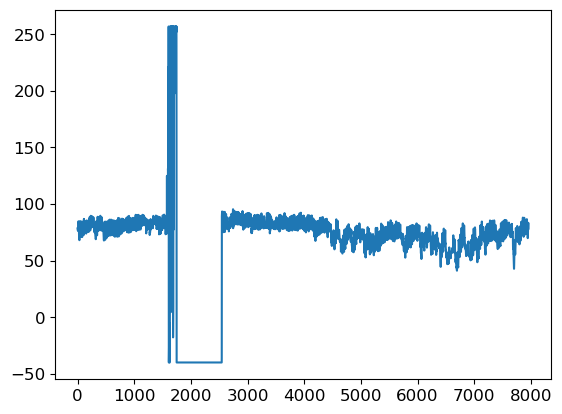

In [7]:
#Plot temp

plt.plot(weather['Air Temp F'])
plt.show()

# Data Cleanup

In [8]:
# Values higher than 100 degrees are probably incorrect readings

weather[weather['Air Temp F']>100]

,date,hour,Air Temp F
1578,6/29/2021,21,124.865
1582,6/30/2021,1,108.674
1595,6/30/2021,14,112.001
1596,6/30/2021,15,131.294
1597,6/30/2021,16,128.849
...,...,...,...
1742,7/6/2021,17,256.820
1743,7/6/2021,18,256.820
1744,7/6/2021,19,251.894
1745,7/6/2021,20,256.820


In [9]:
# Convert all values higher than 100 degrees to null values

weather['Air Temp F'] = np.where(weather['Air Temp F']>100, np.nan, weather['Air Temp F'])

In [10]:
# Values lower than 30 degrees are probably incorrect readings. Convert them to null

weather['Air Temp F'] = np.where(weather['Air Temp F']<30, np.nan, weather['Air Temp F'])

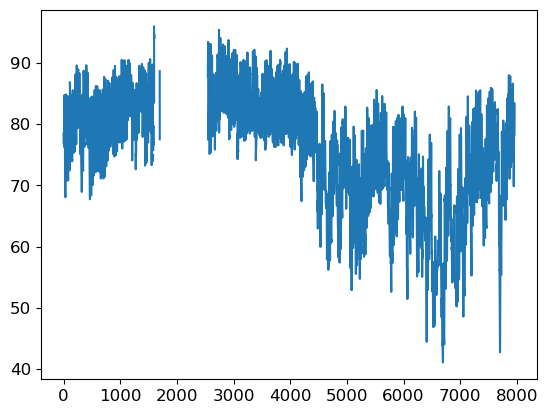

In [11]:
plt.plot(weather['Air Temp F'])
plt.show()

In [12]:
# Remove all null values

weather.dropna(inplace=True)

weather.reset_index(drop=True, inplace=True)

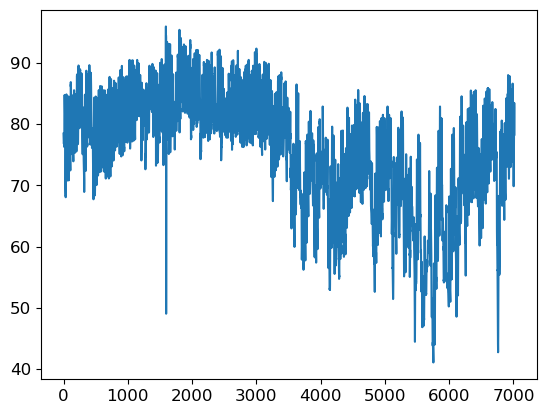

In [13]:
plt.plot(weather['Air Temp F'])
plt.show()

## RESHAPE the data set!

In [14]:
weather.shape

(7017, 3)

In [15]:
# Note that not all days have 24 readings. Some are missing.

weather.shape[0]/24

292.375

In [16]:
# Find the reading count for each day

hour_count = pd.DataFrame(weather.groupby(['date']).count()['hour'])

hour_count

,hour
date,
1/1/2022,24
1/10/2022,24
1/11/2022,24
1/12/2022,24
1/13/2022,24
...,...
9/5/2021,24
9/6/2021,24
9/7/2021,24


In [17]:
# Find the reading counts that are less than 24

hour_count[hour_count['hour']<24]

,hour
date,
3/18/2022,7
4/11/2022,9
4/14/2022,10
6/21/2021,21
6/29/2021,23
6/30/2021,16
7/1/2021,1
7/2/2021,3
7/3/2021,3


In [18]:
# Identify the dates of these records

hour_count[hour_count['hour']<24].index.values

array(['3/18/2022', '4/11/2022', '4/14/2022', '6/21/2021', '6/29/2021',
       '6/30/2021', '7/1/2021', '7/2/2021', '7/3/2021', '7/4/2021',
       '8/10/2021'], dtype=object)

In [19]:
# Find the corresponding index values in the original data set

indexes = weather[weather['date'].isin(hour_count[hour_count['hour']<24].index.values)]

indexes

,date,hour,Air Temp F
1368,6/21/2021,0,84.386
1369,6/21/2021,1,84.137
1370,6/21/2021,2,83.993
1371,6/21/2021,3,83.549
1372,6/21/2021,4,83.210
...,...,...,...
6892,4/14/2022,19,83.732
6893,4/14/2022,20,82.715
6894,4/14/2022,21,81.590
6895,4/14/2022,22,82.085


In [20]:
# Remove these rows from the data set.

weather.drop(indexes.index, axis=0, inplace=True)

weather.reset_index(drop=True)

weather.shape

(6912, 3)

In [21]:
weather

,date,hour,Air Temp F
0,4/25/2021,0,78.431
1,4/25/2021,1,77.801
2,4/25/2021,2,77.402
3,4/25/2021,3,77.135
4,4/25/2021,4,76.871
...,...,...,...
7012,4/19/2022,19,83.075
7013,4/19/2022,20,83.435
7014,4/19/2022,21,83.192
7015,4/19/2022,22,82.670


In [22]:
# All remaining days have 24 readings (for 24 hours)
# There are a total of 288 days

weather.shape[0]/24

288.0

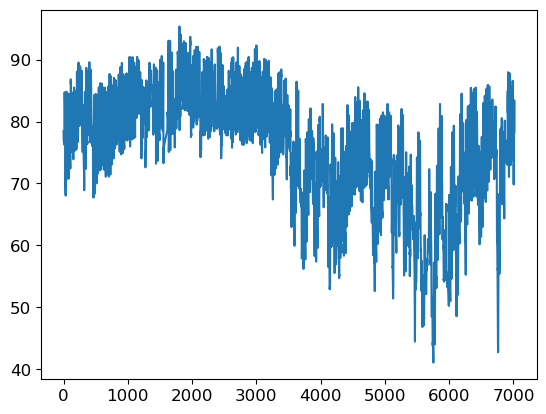

In [23]:
plt.plot(weather['Air Temp F'])
plt.show()

In [24]:
# Re-organize the data set by day and hours

temp = np.array(weather['Air Temp F']).reshape(288,24)

temp

array([[78.431     , 77.801     , 77.40199999, ..., 82.54700001,
        81.716     , 79.196     ],
       [76.02200001, 73.121     , 71.68699999, ..., 84.82699999,
        84.57499999, 82.52900001],
       [80.843     , 78.87500001, 77.05099999, ..., 84.52700001,
        83.99899999, 82.44199999],
       ...,
       [78.26      , 77.54      , 77.495     , ..., 83.98999999,
        83.3       , 79.736     ],
       [78.305     , 77.63      , 77.432     , ..., 84.245     ,
        83.084     , 79.376     ],
       [77.27      , 76.136     , 75.29      , ..., 83.192     ,
        82.67      , 78.26      ]])

In [25]:
# Convert to dataframe

temp_df = pd.DataFrame(temp, columns=np.arange(0,24,1))

temp_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,78.431,77.801,77.402,77.135,76.871,76.814,76.892,76.925,76.580,76.343,...,81.584,81.575,82.445,84.731,84.272,83.252,83.447,82.547,81.716,79.196
1,76.022,73.121,71.687,70.664,69.560,68.864,68.603,68.360,68.360,68.267,...,75.500,77.594,79.691,81.458,83.012,84.080,84.323,84.827,84.575,82.529
2,80.843,78.875,77.051,74.675,73.499,72.950,72.221,71.330,71.048,70.766,...,77.222,79.241,80.933,81.602,82.478,83.795,84.146,84.527,83.999,82.442
3,80.576,78.731,76.739,74.819,73.829,73.052,72.575,71.876,71.306,70.793,...,77.657,79.562,81.014,81.848,82.955,83.813,83.996,84.437,82.913,80.210
4,78.632,77.618,76.040,75.278,74.918,74.561,73.859,73.127,72.785,72.575,...,79.859,82.376,85.808,86.831,86.108,86.459,86.003,84.902,84.413,81.434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,76.910,76.145,75.590,75.380,75.245,74.525,74.750,74.300,74.030,73.040,...,83.300,84.920,81.428,83.210,83.750,85.400,86.225,87.980,86.540,76.784
284,75.200,77.585,77.060,76.055,74.948,74.030,73.400,72.500,71.915,71.600,...,77.108,79.916,83.012,83.930,83.948,86.000,87.215,87.800,86.540,80.168
285,78.260,77.540,77.495,77.540,77.540,76.730,75.920,75.245,74.525,73.400,...,80.330,82.625,84.695,85.640,85.460,84.992,84.470,83.990,83.300,79.736
286,78.305,77.630,77.432,77.135,77.360,76.640,76.505,75.980,75.065,74.120,...,80.810,83.444,84.155,83.435,80.510,86.585,85.235,84.245,83.084,79.376


# Reshape for Standardizing Data

In [26]:
# Let's create a single sequence (i.e., feature) for standardization

temp_1feature = np.array(temp_df).ravel().reshape(-1,1)

temp_1feature.shape

(6912, 1)

In [27]:
temp_1feature

array([[78.431     ],
       [77.801     ],
       [77.40199999],
       ...,
       [83.192     ],
       [82.67      ],
       [78.26      ]])

## Standardize the values

In [28]:
# Next, standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

temp_std = scaler.fit_transform(temp_1feature)

## Reshape the data back to 24-hour format

In [29]:
temp_reshaped = temp_std.reshape(288,24)

temp_reshaped.shape

(288, 24)

In [30]:
#Pandas version of the reshaped data

pd.DataFrame(temp_reshaped, columns=np.arange(0,24,1))

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.391232,0.325683,0.284169,0.256388,0.228920,0.222990,0.231105,0.234539,0.198643,0.173984,...,0.719288,0.718351,0.808871,1.046720,0.998963,0.892836,0.913125,0.819484,0.733022,0.470827
1,0.140586,-0.161251,-0.310453,-0.416891,-0.531758,-0.604174,-0.631330,-0.656613,-0.656613,-0.666289,...,0.086274,0.304145,0.522329,0.706178,0.867865,0.978986,1.004269,1.056708,1.030489,0.817611
2,0.642190,0.437428,0.247649,0.000436,-0.121922,-0.179043,-0.254892,-0.347597,-0.376938,-0.406279,...,0.265440,0.475509,0.651554,0.721161,0.812305,0.949333,0.985853,1.025494,0.970558,0.808559
3,0.614410,0.422445,0.215186,0.015419,-0.087587,-0.168430,-0.218060,-0.290788,-0.350094,-0.403470,...,0.310700,0.508907,0.659982,0.746756,0.861934,0.951206,0.970246,1.016130,0.857565,0.576329
4,0.412145,0.306642,0.142458,0.063175,0.025719,-0.011425,-0.084465,-0.160627,-0.196210,-0.218060,...,0.539809,0.801692,1.158777,1.265216,1.189991,1.226511,1.179066,1.064511,1.013633,0.703681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.232978,0.153383,0.095638,0.073788,0.059742,-0.015171,0.008239,-0.038581,-0.066674,-0.169679,...,0.897830,1.066384,0.703057,0.888466,0.944651,1.116326,1.202164,1.384764,1.234938,0.219868
284,0.055060,0.303209,0.248585,0.144019,0.028840,-0.066674,-0.132222,-0.225864,-0.286730,-0.319505,...,0.253579,0.545740,0.867865,0.963379,0.965252,1.178754,1.305169,1.366036,1.234938,0.571959
285,0.373440,0.298527,0.293845,0.298527,0.298527,0.214250,0.129973,0.059742,-0.015171,-0.132222,...,0.588814,0.827599,1.042974,1.141297,1.122569,1.073876,1.019564,0.969622,0.897830,0.527011
286,0.378122,0.307891,0.287290,0.256388,0.279799,0.204886,0.190840,0.136216,0.041014,-0.057309,...,0.638756,0.912813,0.986789,0.911876,0.607543,1.239620,1.099159,0.996153,0.875356,0.489555


# Split the Data

In [31]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(temp_reshaped, test_size=0.3)

In [32]:
train.shape

(201, 24)

In [33]:
test.shape

(87, 24)

# Create Input and Target values

The first 23 hours will be input to predict the 24th hour reading (i.e., target)

In [34]:
# The first 23 columns (from 0 to 22) are inputs

train_inputs = train[:,:23]


pd.DataFrame(train_inputs, columns=np.arange(0,23,1))

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-1.986317,-1.836491,-1.850537,-1.756896,-1.906722,-1.948861,-1.925450,-1.855219,-1.794353,-1.794353,...,-1.873948,-1.841173,-1.827127,-1.808399,-1.742850,-1.658573,-1.555568,-1.490019,-1.461927,-1.452563
1,0.401532,0.448353,0.485809,0.476445,0.499855,0.518584,0.541994,0.527948,0.541994,0.546676,...,0.607543,0.630953,0.410896,0.663727,0.991471,1.038292,1.347308,1.389446,1.295805,1.075748
2,-1.195049,-1.199731,-1.265280,-1.251234,-1.255916,-1.293373,-1.293373,-1.340193,-1.382332,-1.391696,...,-1.424470,-1.330829,-1.363603,-1.419788,-1.424470,-1.316783,-1.326147,-1.059270,-1.031177,-1.293373
3,-1.616435,-1.602388,-1.635163,-1.653891,-1.761578,-1.799035,-1.799035,-1.799035,-1.850537,-1.883312,...,-1.948861,-1.911404,-1.958225,-1.770942,-1.387014,-1.054588,-0.829849,-0.956264,-0.829849,-1.457245
4,0.982107,0.921241,0.696502,0.499855,0.401532,0.307891,0.270435,0.247024,0.232978,0.209568,...,0.598179,0.762051,0.949333,1.057020,1.234938,1.295805,1.239620,1.202164,1.155343,1.206846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.017603,-0.179043,-0.207135,-0.193089,-0.263320,-0.314823,-0.417828,-0.469330,-0.502105,-0.539561,...,-0.605110,-0.464648,-0.239910,0.055060,0.396850,0.626271,0.776097,0.902512,0.804189,0.443671
197,1.234938,1.099159,0.935287,0.799507,0.752686,0.748004,0.724594,0.724594,0.701184,0.701184,...,1.089795,1.281759,1.436267,1.623549,1.717190,1.867016,2.040252,2.124529,2.152622,2.040252
198,0.209568,0.312573,0.335983,0.335983,0.321937,0.247024,0.228296,0.214250,0.232978,0.275117,...,0.719912,0.949333,1.127251,1.375400,1.637595,1.628231,1.562682,1.431585,1.333262,1.230256
199,-0.001125,0.012921,-0.052627,-0.282048,-0.394418,-0.483377,-0.558290,-0.633202,-0.684705,-0.722162,...,-0.427192,-0.164997,0.289163,0.527948,0.635635,0.930605,0.986789,1.024246,1.103841,0.888466


## Add one more dimension to make it ready for RNNs

In [35]:
#Create an additional dimension for train

train_x = train_inputs[...,np.newaxis]

train_x.shape 

(201, 23, 1)

## Set the target

In [36]:
# The last column (23) is TARGET

train_target = train[:,-1]


pd.DataFrame(train_target, columns=['23'])

,23
0,-1.424470
1,1.019564
2,-1.485337
3,-1.962907
4,1.047656
...,...
196,0.181475
197,0.410896
198,0.982107
199,0.560722


## Repeat for TEST

In [37]:
test.shape

(87, 24)

In [38]:
# The first 23 columns (from 0 to 22) are inputs

test_inputs = test[:,:23]

In [39]:
#Create an additional dimension for test

test_x = test_inputs[...,np.newaxis]

test_x.shape 

(87, 23, 1)

In [40]:
# The last column (23) is TARGET

test_target = test[:,-1]


pd.DataFrame(test_target, columns=['23'])

,23
0,1.180939
1,0.059742
2,-1.003085
3,0.624086
4,-0.347597
...,...
82,-1.892676
83,1.145979
84,-0.033899
85,1.057020


# A normal (cross-sectional) NN

This model assumes that the data is NOT a time-series data set. It treats the data as cross-sectional and the columns being independent of each other.

In [41]:
model = keras.models.Sequential([
    
    keras.layers.Flatten(input_shape=[23, 1]),
    keras.layers.Dense(23, activation='relu'),
    keras.layers.Dense(1, activation=None)
    
])

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100


C:\Users\mural\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5137  
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1955 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1366 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0840 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0985 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0890 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0858 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0881 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0973 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0785 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0748 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0825 
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0705 
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0671 
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0669 
Epoch 16/100
7/7 ━━━━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0304 
Epoch 84/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0258 
Epoch 85/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 
Epoch 86/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.0283
Epoch 87/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0367 
Epoch 88/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0299 
Epoch 89/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0289 
Epoch 90/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279 
Epoch 91/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0285 
Epoch 92/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275 
Epoch 93/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0339 
Epoch 94/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0274 
Epoch 95/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0294 
Epoch 96/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0335 
Epoch 97/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0332 
Epoch 98/100
7/7 ━━━━━

### Predictions

In [42]:
#Predict:
y_pred = model.predict(test_x)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [43]:
# Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [44]:
comparison

,actual,predicted
0,86.021,84.229218
1,75.245,75.389610
2,65.030,68.409355
3,80.669,83.120110
4,71.330,71.388107
...,...,...
82,56.480,59.866241
83,85.685,84.312111
84,74.345,74.541428
85,84.830,85.070183


In [45]:
mean_squared_error(comparison['actual'], comparison['predicted'])

2.986675083334422

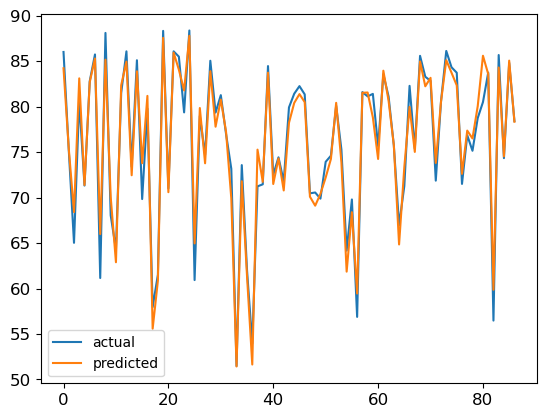

In [46]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Simple RNN

Simplest recurrent neural network

In [47]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', input_shape=[23, 1]),
    keras.layers.Dense(1, activation=None)
])

C:\Users\mural\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0890
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7605 
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5734 
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4247 
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2336 
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1351 
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0714 
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0520 
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0602 
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0467 
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0444 
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0453 
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0425 
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0412 
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0415 
Epoch 16/30
7/7 ━━━━━━━━━━━━━━━━━━━

### Predictions

In [49]:
#Predict:
y_pred = model.predict(test_x)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


In [50]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [51]:
comparison

,actual,predicted
0,86.021,84.400970
1,75.245,74.561264
2,65.030,69.202652
3,80.669,83.635475
4,71.330,71.350571
...,...,...
82,56.480,61.908375
83,85.685,84.085442
84,74.345,74.535606
85,84.830,84.726105


In [52]:
mean_squared_error(comparison['actual'], comparison['predicted'])

3.730937312652881

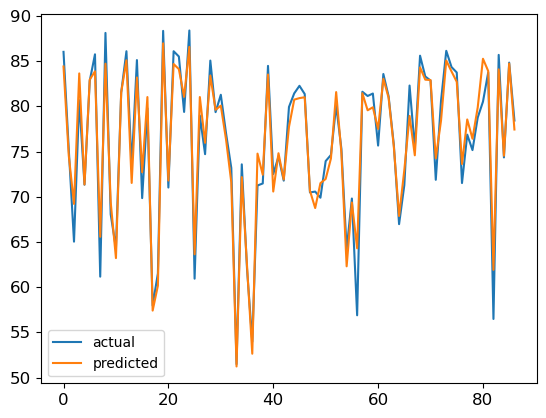

In [53]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

## Simple RNN with more layers

**Be careful: when stacking RNN layers, you have to set "return_sequences" to True. This enables the layer to send a "sequence" of values to the next layer -- jut like how it uses a sequence of values for training. However, if the output of RNN is sent to a DENSE layer, then a single value should be sent. That's why there is no "return sequences" right before DENSE layers.**

In [54]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=True, input_shape=[23, 1]),
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

C:\Users\mural\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.8897
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8155 
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0677 
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7472 
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5723 
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4653 
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3817 
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2280
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0672 
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0730 
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0492 
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0461 
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0400 
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0410 
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0362 
Epoch 16/30
7/7 ━━━━━━━━━━━━━━━━━━━━

### Predictions

In [56]:
#Predict:
y_pred = model.predict(test_x)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000025498549440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


In [57]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [58]:
comparison

,actual,predicted
0,86.021,84.702171
1,75.245,74.658936
2,65.030,68.413322
3,80.669,83.394760
4,71.330,70.917580
...,...,...
82,56.480,59.623814
83,85.685,86.649452
84,74.345,75.309097
85,84.830,84.414436


In [59]:
mean_squared_error(comparison['actual'], comparison['predicted'])

2.4873531719491915

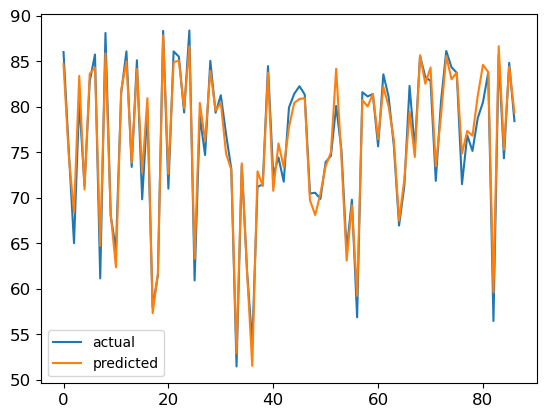

In [60]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with one layer

In [61]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[23, 1]),
    keras.layers.Dense(1, activation=None)
])

C:\Users\mural\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7355
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5994 
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4718 
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3342 
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1836 
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1125 
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0947 
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0793 
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0741 
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0699 
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0644 
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0611 
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0593 
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0573
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0555 
Epoch 16/30
7/7 ━━━━━━━━━━━━━━━━━━━

### Predictions

In [63]:
#Predict:
y_pred = model.predict(test_x)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


In [64]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [65]:
mean_squared_error(comparison['actual'], comparison['predicted'])

4.483083865418347

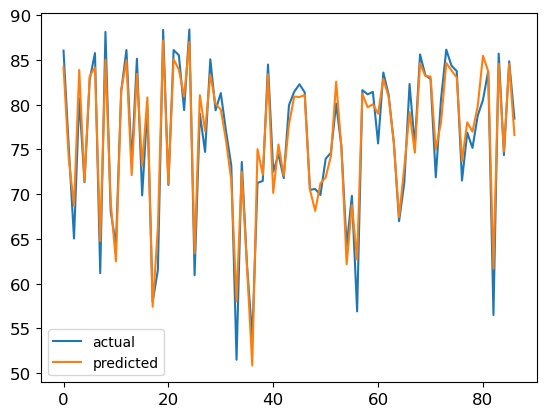

In [66]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with more layers

In [67]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=[23, 1]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

C:\Users\mural\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.6359
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2132
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1164
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0944 
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0803 
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0770
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0765
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0683 
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0654
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0648 
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0630
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0619
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0607
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0593
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0586
Epoch 16/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s

### Predictions

In [69]:
#Predict:
y_pred = model.predict(test_x)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step


In [70]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [71]:
mean_squared_error(comparison['actual'], comparison['predicted'])

6.244908163932641

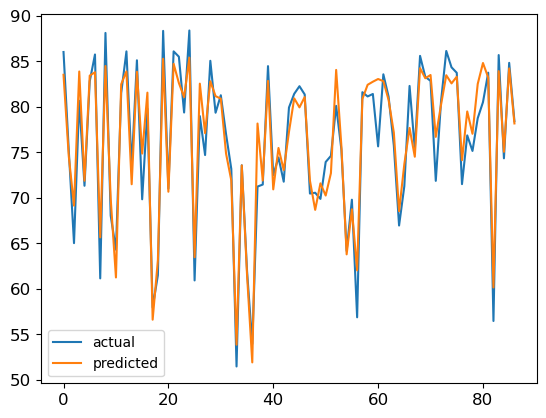

In [72]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# GRU (with more layers)

In [73]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[23, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

C:\Users\mural\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [74]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='RMSprop')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.8265
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5977
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4213
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2524
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1385
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0894
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0650
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0561
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0546
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0534
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0527
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0521
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0515
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0511
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0505
Epoch 16/30
7/7 ━━━━━━━━━━━━━━━━━━

### Predictions

In [75]:
#Predict:
y_pred = model.predict(test_x)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step


In [76]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [77]:
mean_squared_error(comparison['actual'], comparison['predicted'])

3.7386219952688307

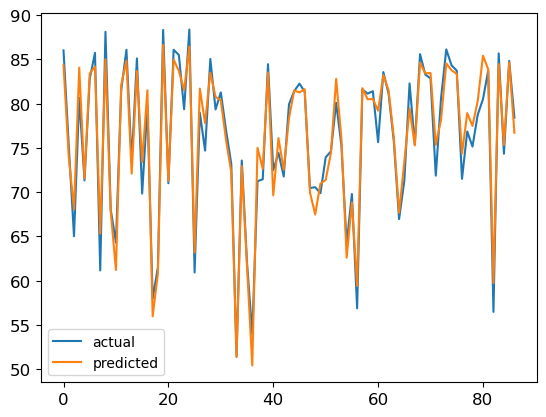

In [78]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Conv1D

### Last Layer: GRU (you can change it to SimpleRNN or LSTM as well)

In [79]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[23, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

C:\Users\mural\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [80]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.6402
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4530
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3464
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2456
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1347
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0665
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0815
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0607
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0624
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0593
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0589
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0588
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0572
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0565
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0559
Epoch 16/30
7/7 ━━━━━━━━━━━━━━━━━━

### Predictions

In [81]:
#Predict:
y_pred = model.predict(test_x)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step


In [82]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [83]:
mean_squared_error(comparison['actual'], comparison['predicted'])

3.2217447469102893

# Forecasting Several Steps Ahead

## Now let's create an RNN that predicts 12 next values at once:

In [84]:
# The first 12 columns (from 0 to 11) are inputs

train_inputs = train[:,:12]

pd.DataFrame(train_inputs, columns=np.arange(0,12,1))

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.986317,-1.836491,-1.850537,-1.756896,-1.906722,-1.948861,-1.925450,-1.855219,-1.794353,-1.794353,-1.761578,-1.770942
1,0.401532,0.448353,0.485809,0.476445,0.499855,0.518584,0.541994,0.527948,0.541994,0.546676,0.518584,0.574768
2,-1.195049,-1.199731,-1.265280,-1.251234,-1.255916,-1.293373,-1.293373,-1.340193,-1.382332,-1.391696,-1.401060,-1.424470
3,-1.616435,-1.602388,-1.635163,-1.653891,-1.761578,-1.799035,-1.799035,-1.799035,-1.850537,-1.883312,-1.939496,-1.972271
4,0.982107,0.921241,0.696502,0.499855,0.401532,0.307891,0.270435,0.247024,0.232978,0.209568,0.200204,0.167429
...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.017603,-0.179043,-0.207135,-0.193089,-0.263320,-0.314823,-0.417828,-0.469330,-0.502105,-0.539561,-0.548925,-0.516151
197,1.234938,1.099159,0.935287,0.799507,0.752686,0.748004,0.724594,0.724594,0.701184,0.701184,0.691820,0.738640
198,0.209568,0.312573,0.335983,0.335983,0.321937,0.247024,0.228296,0.214250,0.232978,0.275117,0.284481,0.211128
199,-0.001125,0.012921,-0.052627,-0.282048,-0.394418,-0.483377,-0.558290,-0.633202,-0.684705,-0.722162,-0.754936,-0.797074


In [85]:
#Create an additional dimension for train

train_x = train_inputs.reshape(201,12,1)

train_x.shape 

(201, 12, 1)

In [86]:
# The last 12 readings (from 12 to 23) are TARGET

train_target = train[:,-12:]

pd.DataFrame(train_target, columns=np.arange(12,24,1))

,12,13,14,15,16,17,18,19,20,21,22,23
0,-1.817763,-1.873948,-1.841173,-1.827127,-1.808399,-1.742850,-1.658573,-1.555568,-1.490019,-1.461927,-1.452563,-1.424470
1,0.790143,0.607543,0.630953,0.410896,0.663727,0.991471,1.038292,1.347308,1.389446,1.295805,1.075748,1.019564
2,-1.415106,-1.424470,-1.330829,-1.363603,-1.419788,-1.424470,-1.316783,-1.326147,-1.059270,-1.031177,-1.293373,-1.485337
3,-2.000363,-1.948861,-1.911404,-1.958225,-1.770942,-1.387014,-1.054588,-0.829849,-0.956264,-0.829849,-1.457245,-1.962907
4,0.415578,0.598179,0.762051,0.949333,1.057020,1.234938,1.295805,1.239620,1.202164,1.155343,1.206846,1.047656
...,...,...,...,...,...,...,...,...,...,...,...,...
196,-0.614474,-0.605110,-0.464648,-0.239910,0.055060,0.396850,0.626271,0.776097,0.902512,0.804189,0.443671,0.181475
197,0.935287,1.089795,1.281759,1.436267,1.623549,1.717190,1.867016,2.040252,2.124529,2.152622,2.040252,0.410896
198,0.401532,0.719912,0.949333,1.127251,1.375400,1.637595,1.628231,1.562682,1.431585,1.333262,1.230256,0.982107
199,-0.670659,-0.427192,-0.164997,0.289163,0.527948,0.635635,0.930605,0.986789,1.024246,1.103841,0.888466,0.560722


## Repeat for TEST

In [87]:
# The first 12 columns (from 0 to 11) are inputs

test_inputs = test[:,:12]

pd.DataFrame(test_inputs, columns=np.arange(0,12,1))

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.023621,0.456468,0.432746,0.549173,0.520144,0.538248,0.608479,0.528260,0.441798,0.325371,0.270435,0.386550
1,0.125291,0.050378,-0.043263,0.017603,-0.090084,-0.174361,-0.235228,-0.193089,-0.272684,-0.385053,-0.403782,-0.389736
2,-0.445920,-0.497423,-0.516151,-0.511469,-0.544243,-0.614474,-0.637885,-0.609792,-0.619156,-0.651931,-0.605110,-0.708115
3,0.791704,0.651554,0.591936,0.510780,0.529196,0.490803,0.448353,0.331613,0.312885,0.323810,0.280111,0.374688
4,-0.403782,-0.417828,-0.455284,-0.544243,-0.619156,-0.656613,-0.698751,-0.759618,-0.815803,-0.867305,-0.909444,-0.923490
...,...,...,...,...,...,...,...,...,...,...,...,...
82,-0.047945,-0.076038,-0.108812,-0.155633,-0.174361,-0.146269,-0.090084,-0.076038,-0.450602,-0.750254,-0.839213,-0.974993
83,0.982107,0.907194,0.925923,0.701184,0.574768,0.513902,0.438989,0.406214,0.387486,0.387486,0.373440,0.392168
84,-0.202453,-0.272684,-0.347597,-0.342915,-0.445920,-0.534879,-0.600428,-0.633202,-0.628520,-0.670659,-0.689387,-0.708115
85,1.038292,0.982107,0.958697,0.916558,0.846328,0.841646,0.804189,0.752686,0.752686,0.724594,0.663727,0.743322


In [88]:
#Create an additional dimension for test

test_x = test_inputs.reshape(87,12,1)

test_x.shape 

(87, 12, 1)

In [89]:
# The last 12 columns are TARGET

test_target = test[:,-12:]

pd.DataFrame(test_target, columns=np.arange(12,24,1))

,12,13,14,15,16,17,18,19,20,21,22,23
0,0.595369,0.772351,0.890963,0.959946,1.159089,1.296429,1.464983,1.477157,1.546139,1.497446,1.303296,1.180939
1,-0.385053,-0.202453,-0.052627,0.003557,0.073788,0.167429,0.209568,0.312573,0.345347,0.396850,0.242342,0.059742
2,-0.825167,-0.806439,-0.431874,-0.352279,-0.427192,-0.310141,-0.188407,0.031650,-0.033899,-0.108812,-0.436556,-1.003085
3,0.583820,0.839461,1.129124,1.293932,1.375400,1.511804,1.636659,1.641965,1.550862,1.386013,1.051090,0.624086
4,-0.909444,-1.007767,-0.960946,-0.698751,-0.314823,0.415578,0.560722,0.659045,0.340665,0.069106,-0.169679,-0.347597
...,...,...,...,...,...,...,...,...,...,...,...,...
82,-1.195049,-1.312101,-1.227824,-1.049906,-1.092044,-1.096726,-1.007767,-1.026495,-1.106090,-1.241870,-1.630481,-1.892676
83,0.626271,0.715230,0.916558,1.136615,1.469041,1.651641,1.796785,1.515862,1.450313,1.220892,1.384764,1.145979
84,-0.764300,-0.661295,-0.352279,0.026968,0.331301,0.509219,0.654363,0.630953,0.598179,0.457717,0.223614,-0.033899
85,0.265752,0.893148,1.267713,1.108523,1.314533,1.628231,1.548636,1.600139,1.454995,1.511180,1.277077,1.057020


# GRU

In [90]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[12, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(12, activation=None)
])

C:\Users\mural\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [91]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.1226
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0580 
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9942
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9235 
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8360
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7216
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5742
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4039 
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3048 
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2443 
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2047
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1830 
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1757 
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1682
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1642
Epoch 16/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0

### Predictions

In [92]:
#Predict:
y_pred = model.predict(test_x)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step


In [93]:
#Remember, these are standardized values. 

actual = pd.DataFrame(scaler.inverse_transform(test_target))
predicted = pd.DataFrame(scaler.inverse_transform(y_pred))

In [94]:
actual

,0,1,2,3,4,5,6,7,8,9,10,11
0,80.393,82.094,83.234,83.897,85.811,87.131,88.751,88.868,89.531000,89.063,87.197,86.021
1,70.970,72.725,74.165,74.705,75.380,76.280,76.685,77.675,77.990000,78.485,77.000,75.245
2,66.740,66.920,70.520,71.285,70.565,71.690,72.860,74.975,74.345000,73.625,70.475,65.030
3,80.282,82.739,85.523,87.107,87.890,89.201,90.401,90.452,89.576393,87.992,84.773,80.669
4,65.930,64.985,65.435,67.955,71.645,78.665,80.060,81.005,77.945000,75.335,73.040,71.330
...,...,...,...,...,...,...,...,...,...,...,...,...
82,63.185,62.060,62.870,64.580,64.175,64.130,64.985,64.805,64.040000,62.735,59.000,56.480
83,80.690,81.545,83.480,85.595,88.790,90.545,91.940,89.240,88.610000,86.405,87.980,85.685
84,67.325,68.315,71.285,74.930,77.855,79.565,80.960,80.735,80.420000,79.070,76.820,74.345
85,77.225,83.255,86.855,85.325,87.305,90.320,89.555,90.050,88.655000,89.195,86.945,84.830


In [95]:
predicted

,0,1,2,3,4,5,6,7,8,9,10,11
0,79.838219,81.647568,82.867516,84.543694,85.878853,86.977158,87.285919,87.232193,86.878975,86.520874,84.538734,82.718163
1,72.702789,73.891304,76.271217,78.322121,80.039520,81.610161,83.154922,83.962692,82.929581,82.317734,81.144211,78.877655
2,68.502243,69.589371,72.679146,73.916588,75.890816,77.446968,79.254936,80.024666,78.728760,78.830688,76.767326,74.733810
3,79.517372,81.337334,82.595955,84.287560,85.567932,86.631706,87.028656,87.057159,86.705833,86.337624,84.301819,82.573799
4,66.428917,67.427101,70.586800,71.889206,74.069901,75.663338,77.666039,78.491669,77.256554,77.347511,75.201073,72.998329
...,...,...,...,...,...,...,...,...,...,...,...,...
82,69.746147,70.796188,73.203819,75.461136,77.443222,79.081749,81.062332,81.928680,81.161255,80.372086,79.407372,76.689941
83,79.981949,81.978325,83.083206,84.778023,86.220009,87.309456,87.578041,87.548096,87.214844,86.786964,84.779198,82.905220
84,68.537895,69.600281,72.584496,73.979713,76.052246,77.588394,79.415550,80.271179,79.019814,78.916733,77.040291,74.885338
85,81.724731,84.061249,84.837074,86.108734,88.120674,89.627739,89.173416,88.777229,88.149292,87.928703,85.803604,83.524109


In [96]:
comparison

,actual,predicted
0,86.021,84.198189
1,75.245,74.063179
2,65.030,68.446991
3,80.669,83.200935
4,71.330,71.357285
...,...,...
82,56.480,60.121250
83,85.685,84.346680
84,74.345,74.642365
85,84.830,84.673004


In [97]:
mean_squared_error(actual, predicted)

20.965529678080184

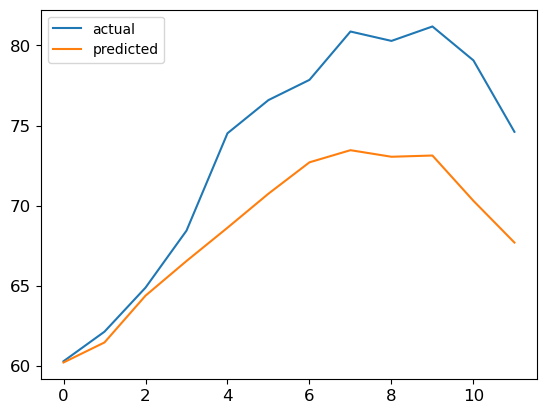

In [98]:
# Plot a random row to see the accuracy of predictions

random_row = np.random.randint(low=0, high=86)

plt.plot(actual.iloc[random_row], label='actual')
plt.plot(predicted.iloc[random_row], label='predicted')

plt.legend()
plt.show()

# Sliding window

Prior 18 hours predicts next 6 hours

In [99]:
steps_for_prediction = 18
steps_to_predict = 6

#Be careful: sums to 24 hours

In [100]:
train

array([[-1.98631703e+00, -1.83649120e+00, -1.85053737e+00, ...,
        -1.46192662e+00, -1.45256251e+00, -1.42447016e+00],
       [ 4.01532160e-01,  4.48352732e-01,  4.85809190e-01, ...,
         1.29580509e+00,  1.07574840e+00,  1.01956372e+00],
       [-1.19504936e+00, -1.19973142e+00, -1.26528022e+00, ...,
        -1.03117735e+00, -1.29337256e+00, -1.48533691e+00],
       ...,
       [ 2.09567813e-01,  3.12573072e-01,  3.35983359e-01, ...,
         1.33326155e+00,  1.23025629e+00,  9.82107257e-01],
       [-1.12476250e-03,  1.29214092e-02, -5.26273921e-02, ...,
         1.10384075e+00,  8.88466112e-01,  5.60722106e-01],
       [ 7.43322338e-01,  6.63727365e-01,  5.93496507e-01, ...,
         1.08979457e+00,  8.60373769e-01,  7.19912052e-01]])

In [101]:
train.flatten().shape

(4824,)

In [102]:
train_inputs_sw = []
train_target_sw = []

for i in range(0,4824-24):
    input_row = train.flatten()[i:i+steps_for_prediction]
    target_row = train.flatten()[i+steps_for_prediction:i+steps_for_prediction+steps_to_predict]
    train_inputs_sw.append((input_row))
    train_target_sw.append((target_row))

In [103]:
train_inputs = np.vstack(train_inputs_sw)

train_targets = np.vstack(train_target_sw)

In [104]:
train_targets.shape

(4800, 6)

In [105]:
# Repeat for test

test_inputs_sw = []
test_target_sw = []

for i in range(0,test.flatten().shape[0]-24):
    input_row = test.flatten()[i:i+steps_for_prediction]
    target_row = test.flatten()[i+steps_for_prediction:i+steps_for_prediction+steps_to_predict]
    test_inputs_sw.append((input_row))
    test_target_sw.append((target_row))
    
test_inputs = np.vstack(test_inputs_sw)

test_targets = np.vstack(test_target_sw)

# GRU

In [106]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[18, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(steps_to_predict, activation=None)
])

C:\Users\mural\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [107]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_inputs, train_targets, epochs=30)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.8148
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2890
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2679
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2583
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2467
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2380
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2322
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2282
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2248
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2218
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2185
Epoch 12/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2145
Epoch 13/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2117
Epoch 14/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2099
Epoch 15/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - lo

### Predictions

In [108]:
#Predict:
y_pred = model.predict(test_inputs)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [109]:
#Remember, these are standardized values. 

actual = pd.DataFrame(scaler.inverse_transform(test_targets))
predicted = pd.DataFrame(scaler.inverse_transform(y_pred))

In [110]:
actual

,0,1,2,3,4,5
0,88.751,88.868,89.531,89.063,87.197,86.021
1,88.868,89.531,89.063,87.197,86.021,75.875
2,89.531,89.063,87.197,86.021,75.875,75.155
3,89.063,87.197,86.021,75.875,75.155,74.255
4,87.197,86.021,75.875,75.155,74.255,74.840
...,...,...,...,...,...,...
2059,76.781,76.880,77.393,78.770,79.073,79.235
2060,76.880,77.393,78.770,79.073,79.235,78.611
2061,77.393,78.770,79.073,79.235,78.611,78.470
2062,78.770,79.073,79.235,78.611,78.470,78.722


In [111]:
predicted

,0,1,2,3,4,5
0,88.310028,87.937119,86.914017,87.306145,85.821785,83.302307
1,88.823555,87.545113,85.448166,82.817818,79.667137,75.720818
2,88.841789,87.001457,84.215424,80.769844,77.254166,74.218338
3,89.207870,86.594757,82.911316,78.999619,75.857544,73.267311
4,87.777573,84.302780,79.897491,75.983704,73.643730,71.980865
...,...,...,...,...,...,...
2059,78.141960,79.134300,80.630165,82.411018,84.312195,85.066719
2060,78.427368,79.652397,81.196129,83.050873,84.637108,85.208939
2061,78.358490,79.738487,81.469185,83.410233,84.785446,85.228706
2062,78.916962,80.340263,81.941551,83.771973,84.839607,85.155396


In [112]:
actual.head

<bound method NDFrame.head of            0       1       2       3       4       5
0     88.751  88.868  89.531  89.063  87.197  86.021
1     88.868  89.531  89.063  87.197  86.021  75.875
2     89.531  89.063  87.197  86.021  75.875  75.155
3     89.063  87.197  86.021  75.875  75.155  74.255
4     87.197  86.021  75.875  75.155  74.255  74.840
...      ...     ...     ...     ...     ...     ...
2059  76.781  76.880  77.393  78.770  79.073  79.235
2060  76.880  77.393  78.770  79.073  79.235  78.611
2061  77.393  78.770  79.073  79.235  78.611  78.470
2062  78.770  79.073  79.235  78.611  78.470  78.722
2063  79.073  79.235  78.611  78.470  78.722  78.857

[2064 rows x 6 columns]>

In [113]:
predicted.head

<bound method NDFrame.head of               0          1          2          3          4          5
0     88.310028  87.937119  86.914017  87.306145  85.821785  83.302307
1     88.823555  87.545113  85.448166  82.817818  79.667137  75.720818
2     88.841789  87.001457  84.215424  80.769844  77.254166  74.218338
3     89.207870  86.594757  82.911316  78.999619  75.857544  73.267311
4     87.777573  84.302780  79.897491  75.983704  73.643730  71.980865
...         ...        ...        ...        ...        ...        ...
2059  78.141960  79.134300  80.630165  82.411018  84.312195  85.066719
2060  78.427368  79.652397  81.196129  83.050873  84.637108  85.208939
2061  78.358490  79.738487  81.469185  83.410233  84.785446  85.228706
2062  78.916962  80.340263  81.941551  83.771973  84.839607  85.155396
2063  80.446922  81.656242  82.914757  84.339928  84.951714  85.159103

[2064 rows x 6 columns]>

In [114]:
mean_squared_error(actual, predicted)

20.466312054704357

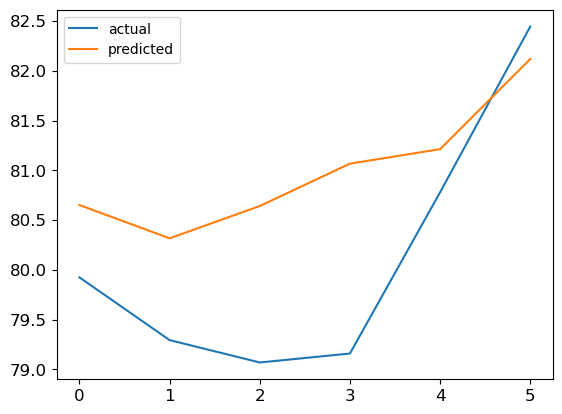

In [121]:
# Plot a random row to see the accuracy of predictions

random_row = np.random.randint(low=0, high=2063)

plt.plot(actual.iloc[random_row], label='actual')
plt.plot(predicted.iloc[random_row], label='predicted')

plt.legend()
plt.show()

## We could try using 6 steps to predict the next 6 steps (maybe 18 steps is too long)